In [1]:
from rosbags.rosbag1 import Reader
from rosbags.typesys import get_typestore, Stores
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

# Camera serial numbers from the configuration file
camera_serials = [
    '135122071615',  # master, number 1
    '141722071426',  # number 2
    '142122070087',  # number 3
    '141722073953',  # number 4
    '137322071489',  # number 5
    '141722079467',  # number 6
    '141722075184',  # number 7
    '138422075916',  # number 8
]

print(f"Expected camera serial numbers: {camera_serials}")


Expected camera serial numbers: ['135122071615', '141722071426', '142122070087', '141722073953', '137322071489', '141722079467', '141722075184', '138422075916']


In [2]:
# Path to the bag file
bag_file = Path("/workspace/NS2/data/group_d_seq_1_2025-10-30-16-13-14.bag")

# Open the ROS bag file and inspect its contents
with Reader(bag_file) as reader:
    print(f"Bag file loaded: {bag_file}")
    print(f"Duration: {reader.duration / 1e9:.2f} seconds")
    print(f"\nTopics in bag file:")
    
    for connection in reader.connections:
        print(f"  {connection.topic}: {connection.msgtype} ({connection.msgcount} messages)")


Bag file loaded: /workspace/NS2/data/group_d_seq_1_2025-10-30-16-13-14.bag
Duration: 121.14 seconds

Topics in bag file:
  /tf_static: tf2_msgs/msg/TFMessage (1 messages)
  /tf_static: tf2_msgs/msg/TFMessage (1 messages)
  /camera/135122071615/depth/metadata: realsense2_camera/msg/Metadata (3637 messages)
  /camera/135122071615/color/image_raw/compressed: sensor_msgs/msg/CompressedImage (3632 messages)
  /tf_static: tf2_msgs/msg/TFMessage (1 messages)
  /tf_static: tf2_msgs/msg/TFMessage (1 messages)
  /tf_static: tf2_msgs/msg/TFMessage (1 messages)
  /tf_static: tf2_msgs/msg/TFMessage (1 messages)
  /tf_static: tf2_msgs/msg/TFMessage (1 messages)
  /camera/138422075916/color/camera_info: sensor_msgs/msg/CameraInfo (3632 messages)
  /camera/138422075916/aligned_depth_to_color/image_raw: sensor_msgs/msg/Image (3631 messages)
  /tf_static: tf2_msgs/msg/TFMessage (1 messages)
  /camera/138422075916/color/image_raw/compressed: sensor_msgs/msg/CompressedImage (3632 messages)
  /camera/14172

In [3]:
# Dictionary to store one frame from each camera
camera_frames = {}
camera_info = {}

# Get typestore for ROS1
typestore = get_typestore(Stores.ROS1_NOETIC)

# Open bag file and extract one frame from each camera
with Reader(bag_file) as reader:
    # Find all color image topics for each camera (look for compressed images)
    color_topics = {}
    for connection in reader.connections:
        topic = connection.topic
        # Look for color image topics - can be /compressed or /image_raw
        if '/color/image_raw' in topic and 'compressed' in topic.lower():
            # Extract serial number from topic name
            parts = topic.split('/')
            for part in parts:
                if len(part) == 12 and part.isdigit():  # Serial numbers are 12 digits
                    color_topics[part] = (topic, connection.msgtype)
                    break
    
    print(f"Found {len(color_topics)} color image topics:")
    for serial, (topic, msgtype) in color_topics.items():
        print(f"  Camera {serial}: {topic} ({msgtype})")
    
    # Extract one frame from each camera
    for serial in camera_serials:
        if serial in color_topics:
            topic, msgtype = color_topics[serial]
            # Get the first message from this topic
            for connection, timestamp, rawdata in reader.messages(connections=reader.connections):
                if connection.topic == topic:
                    try:
                        # Deserialize the compressed image message
                        msg = typestore.deserialize_ros1(rawdata, connection.msgtype)
                        
                        # Extract compressed image data
                        compressed_data = bytes(msg.data)
                        image_format = msg.format
                        
                        # Decode compressed image using OpenCV
                        np_arr = np.frombuffer(compressed_data, np.uint8)
                        image_bgr = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
                        
                        if image_bgr is not None:
                            # Convert BGR to RGB for matplotlib
                            image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
                            camera_frames[serial] = image_rgb
                            height, width = image_rgb.shape[:2]
                            camera_info[serial] = {'width': width, 'height': height, 'format': image_format}
                            print(f"Captured frame from camera {serial}: {width}x{height} (format: {image_format})")
                        else:
                            print(f"Failed to decode image from camera {serial}")
                        
                        break  # Only get first frame
                    except Exception as e:
                        print(f"Error processing {serial}: {e}")
                        import traceback
                        traceback.print_exc()
                        break

print(f"\nTotal cameras captured: {len(camera_frames)}")


Found 8 color image topics:
  Camera 135122071615: /camera/135122071615/color/image_raw/compressed (sensor_msgs/msg/CompressedImage)
  Camera 138422075916: /camera/138422075916/color/image_raw/compressed (sensor_msgs/msg/CompressedImage)
  Camera 141722071426: /camera/141722071426/color/image_raw/compressed (sensor_msgs/msg/CompressedImage)
  Camera 141722079467: /camera/141722079467/color/image_raw/compressed (sensor_msgs/msg/CompressedImage)
  Camera 142122070087: /camera/142122070087/color/image_raw/compressed (sensor_msgs/msg/CompressedImage)
  Camera 137322071489: /camera/137322071489/color/image_raw/compressed (sensor_msgs/msg/CompressedImage)
  Camera 141722075184: /camera/141722075184/color/image_raw/compressed (sensor_msgs/msg/CompressedImage)
  Camera 141722073953: /camera/141722073953/color/image_raw/compressed (sensor_msgs/msg/CompressedImage)
Captured frame from camera 135122071615: 640x480 (format: rgb8; jpeg compressed bgr8)
Captured frame from camera 141722071426: 640x4

Camera 1 (135122071615): 640x480
Camera 2 (141722071426): 640x480
Camera 3 (142122070087): 640x480
Camera 4 (141722073953): 640x480
Camera 5 (137322071489): 640x480
Camera 6 (141722079467): 640x480
Camera 7 (141722075184): 640x480
Camera 8 (138422075916): 640x480


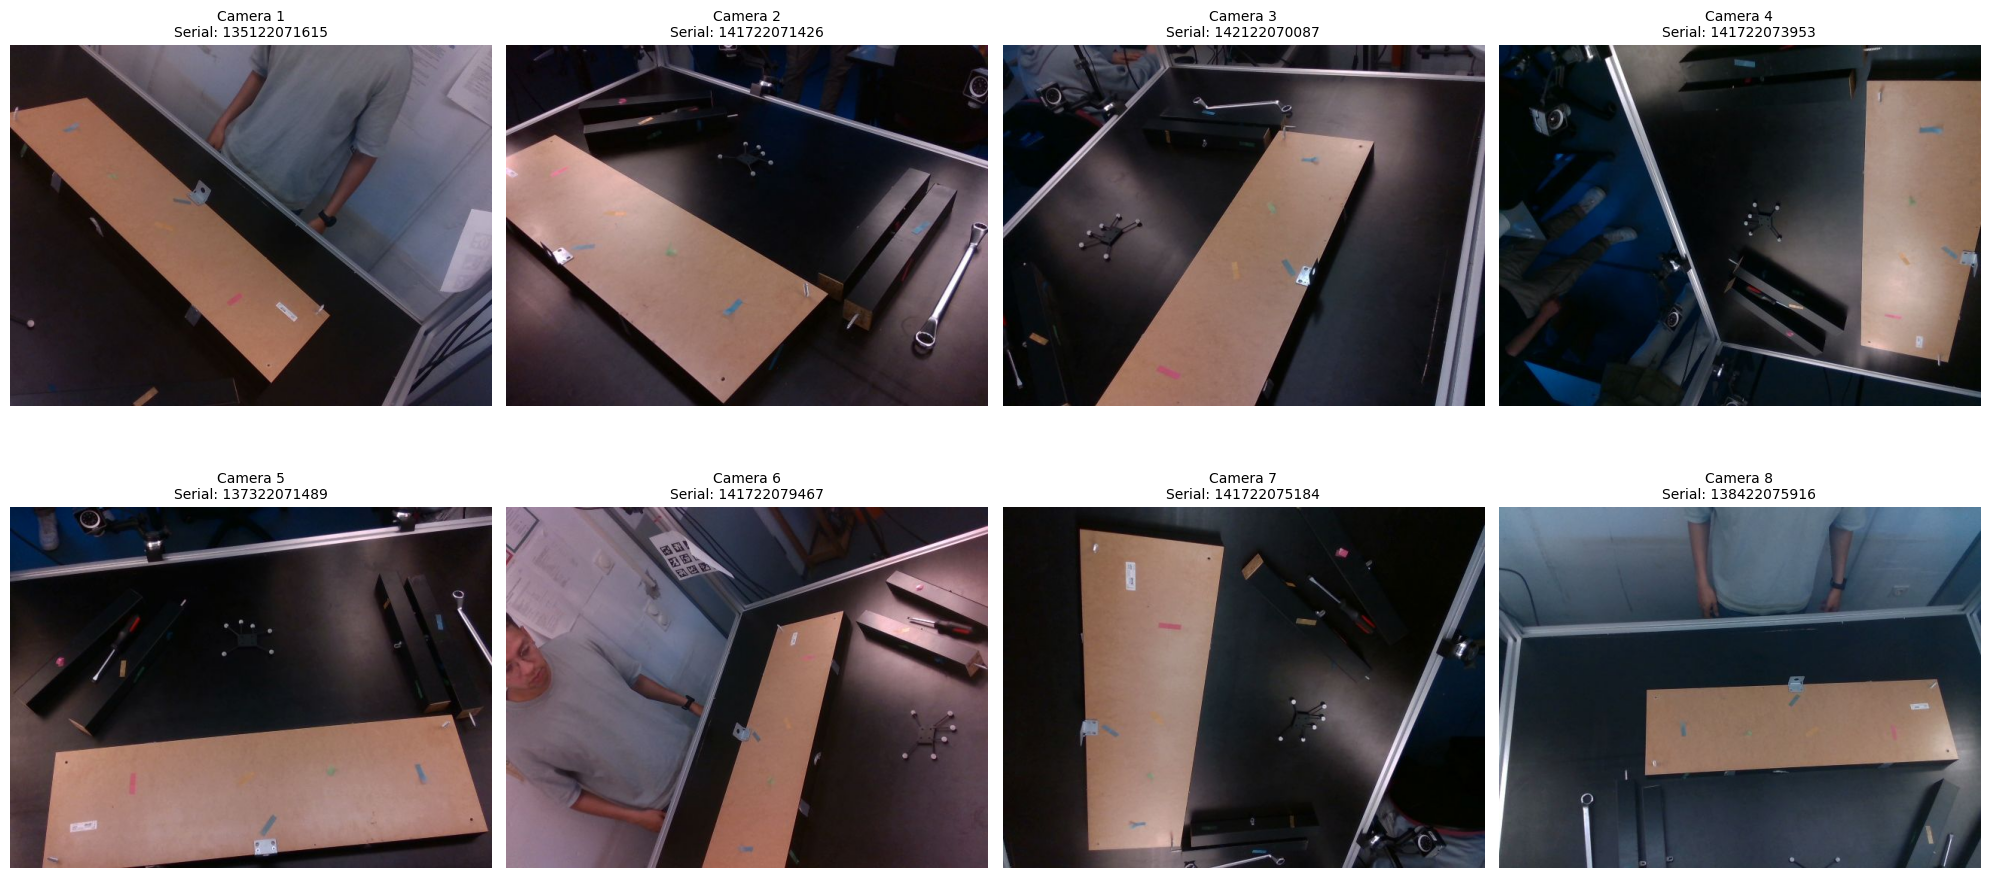


Displayed 8 camera views


In [4]:
# Display all 8 camera views in a grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Display frames in the order of camera numbers (as defined in the config file)
for idx, serial in enumerate(camera_serials):
    if serial in camera_frames:
        # Display the RGB image
        color_image = camera_frames[serial]
        axes[idx].imshow(color_image)
        
        # Get camera number from the config (1-8)
        camera_number = idx + 1
        axes[idx].set_title(f'Camera {camera_number}\nSerial: {serial}', fontsize=10)
        axes[idx].axis('off')
        
        # Print info
        if serial in camera_info:
            info = camera_info[serial]
            print(f"Camera {camera_number} ({serial}): {info['width']}x{info['height']}")
    else:
        axes[idx].text(0.5, 0.5, f'Camera {idx+1}\nNo data', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'Camera {idx+1}\nSerial: {serial}', fontsize=10)
        axes[idx].axis('off')

plt.tight_layout()
#plt.savefig('/workspace/NS2/8_camera_views.jpg', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nDisplayed {len(camera_frames)} camera views")


In [11]:
import os
from pathlib import Path

# Configuration
num_train_frames = 100
num_val_frames = 10
base_data_dir = Path("/workspace/NS2/data")
train_dir = base_data_dir / "train_images"
val_dir = base_data_dir / "val_images"

# Create directory structure for each camera
for serial in camera_serials:
    (train_dir / serial).mkdir(parents=True, exist_ok=True)
    (val_dir / serial).mkdir(parents=True, exist_ok=True)
    print(f"Created directories for camera {serial}")

print(f"\nDirectory structure created:")
print(f"  Training: {train_dir}")
print(f"  Validation: {val_dir}")


Created directories for camera 135122071615
Created directories for camera 141722071426
Created directories for camera 142122070087
Created directories for camera 141722073953
Created directories for camera 137322071489
Created directories for camera 141722079467
Created directories for camera 141722075184
Created directories for camera 138422075916

Directory structure created:
  Training: /workspace/NS2/data/train_images
  Validation: /workspace/NS2/data/val_images


In [12]:
# First, count total frames for each camera
camera_frame_counts = {}

with Reader(bag_file) as reader:
    # Find all color image topics for each camera
    color_topics = {}
    for connection in reader.connections:
        topic = connection.topic
        if '/color/image_raw' in topic and 'compressed' in topic.lower():
            parts = topic.split('/')
            for part in parts:
                if len(part) == 12 and part.isdigit():
                    color_topics[part] = (topic, connection.msgtype, connection.msgcount)
                    camera_frame_counts[part] = connection.msgcount
                    break

print("Frame counts per camera:")
for serial in camera_serials:
    if serial in camera_frame_counts:
        print(f"  Camera {serial}: {camera_frame_counts[serial]} frames")


Frame counts per camera:
  Camera 135122071615: 3632 frames
  Camera 141722071426: 3632 frames
  Camera 142122070087: 3632 frames
  Camera 141722073953: 3631 frames
  Camera 137322071489: 3631 frames
  Camera 141722079467: 3632 frames
  Camera 141722075184: 3631 frames
  Camera 138422075916: 3632 frames


In [13]:
# Calculate which frames to extract for each camera
# We'll use evenly spaced indices across the whole video
camera_train_indices = {}
camera_val_indices = {}

for serial in camera_serials:
    if serial in camera_frame_counts:
        total_frames = camera_frame_counts[serial]
        
        # Calculate evenly spaced train indices
        train_step = total_frames / num_train_frames
        camera_train_indices[serial] = set(int(i * train_step) for i in range(num_train_frames))
        
        # Calculate evenly spaced validation indices (offset so they don't overlap)
        # Use offset to ensure validation frames are between training frames
        val_step = total_frames / num_val_frames
        val_offset = val_step / 2  # Offset by half step to avoid train frames
        camera_val_indices[serial] = set(int(val_offset + i * val_step) for i in range(num_val_frames))
        
        print(f"Camera {serial}:")
        print(f"  Total frames: {total_frames}")
        print(f"  Train indices: {min(camera_train_indices[serial])} to {max(camera_train_indices[serial])} (every ~{train_step:.1f} frames)")
        print(f"  Val indices: {min(camera_val_indices[serial])} to {max(camera_val_indices[serial])} (every ~{val_step:.1f} frames)")


Camera 135122071615:
  Total frames: 3632
  Train indices: 0 to 3595 (every ~36.3 frames)
  Val indices: 181 to 3450 (every ~363.2 frames)
Camera 141722071426:
  Total frames: 3632
  Train indices: 0 to 3595 (every ~36.3 frames)
  Val indices: 181 to 3450 (every ~363.2 frames)
Camera 142122070087:
  Total frames: 3632
  Train indices: 0 to 3595 (every ~36.3 frames)
  Val indices: 181 to 3450 (every ~363.2 frames)
Camera 141722073953:
  Total frames: 3631
  Train indices: 0 to 3594 (every ~36.3 frames)
  Val indices: 181 to 3449 (every ~363.1 frames)
Camera 137322071489:
  Total frames: 3631
  Train indices: 0 to 3594 (every ~36.3 frames)
  Val indices: 181 to 3449 (every ~363.1 frames)
Camera 141722079467:
  Total frames: 3632
  Train indices: 0 to 3595 (every ~36.3 frames)
  Val indices: 181 to 3450 (every ~363.2 frames)
Camera 141722075184:
  Total frames: 3631
  Train indices: 0 to 3594 (every ~36.3 frames)
  Val indices: 181 to 3449 (every ~363.1 frames)
Camera 138422075916:
  Tota

In [14]:
# Extract and save frames
print("Extracting and saving frames...")
print("This may take a few minutes...\n")

# Track progress for each camera
camera_frame_counter = {serial: 0 for serial in camera_serials}
camera_train_saved = {serial: 0 for serial in camera_serials}
camera_val_saved = {serial: 0 for serial in camera_serials}

with Reader(bag_file) as reader:
    # Get typestore for ROS1
    typestore = get_typestore(Stores.ROS1_NOETIC)
    
    # Find all color image topics
    color_topics = {}
    for connection in reader.connections:
        topic = connection.topic
        if '/color/image_raw' in topic and 'compressed' in topic.lower():
            parts = topic.split('/')
            for part in parts:
                if len(part) == 12 and part.isdigit():
                    color_topics[part] = topic
                    break
    
    # Process all messages
    for connection, timestamp, rawdata in reader.messages():
        # Check if this is a color image topic
        topic = connection.topic
        
        # Find which camera this message belongs to
        camera_serial = None
        for serial, camera_topic in color_topics.items():
            if topic == camera_topic:
                camera_serial = serial
                break
        
        if camera_serial is None:
            continue
        
        # Get current frame index for this camera
        frame_idx = camera_frame_counter[camera_serial]
        
        # Check if we should save this frame
        should_save_train = frame_idx in camera_train_indices.get(camera_serial, set())
        should_save_val = frame_idx in camera_val_indices.get(camera_serial, set())
        
        if should_save_train or should_save_val:
            try:
                # Deserialize the compressed image message
                msg = typestore.deserialize_ros1(rawdata, connection.msgtype)
                
                # Extract compressed image data
                compressed_data = bytes(msg.data)
                
                # Decode compressed image using OpenCV
                np_arr = np.frombuffer(compressed_data, np.uint8)
                image_bgr = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
                
                if image_bgr is not None:
                    if should_save_train:
                        # Save training frame
                        frame_num = camera_train_saved[camera_serial]
                        output_path = train_dir / camera_serial / f"{frame_num:06d}.jpg"
                        cv2.imwrite(str(output_path), image_bgr)
                        camera_train_saved[camera_serial] += 1
                        
                        if camera_train_saved[camera_serial] % 20 == 0:
                            print(f"Camera {camera_serial}: saved {camera_train_saved[camera_serial]}/{num_train_frames} train frames")
                    
                    if should_save_val:
                        # Save validation frame
                        frame_num = camera_val_saved[camera_serial]
                        output_path = val_dir / camera_serial / f"{frame_num:06d}.jpg"
                        cv2.imwrite(str(output_path), image_bgr)
                        camera_val_saved[camera_serial] += 1
                        
            except Exception as e:
                print(f"Error processing frame {frame_idx} from camera {camera_serial}: {e}")
        
        # Increment frame counter for this camera
        camera_frame_counter[camera_serial] += 1

print("\n" + "="*60)
print("Frame extraction complete!")
print("="*60)
for serial in camera_serials:
    print(f"\nCamera {serial}:")
    print(f"  Training frames saved: {camera_train_saved[serial]}/{num_train_frames}")
    print(f"  Validation frames saved: {camera_val_saved[serial]}/{num_val_frames}")
    print(f"  Train dir: {train_dir / serial}")
    print(f"  Val dir: {val_dir / serial}")


Extracting and saving frames...
This may take a few minutes...

Camera 137322071489: saved 20/100 train frames
Camera 141722075184: saved 20/100 train frames
Camera 138422075916: saved 20/100 train frames
Camera 141722079467: saved 20/100 train frames
Camera 141722073953: saved 20/100 train frames
Camera 135122071615: saved 20/100 train frames
Camera 142122070087: saved 20/100 train frames
Camera 141722071426: saved 20/100 train frames
Camera 138422075916: saved 40/100 train frames
Camera 142122070087: saved 40/100 train frames
Camera 141722079467: saved 40/100 train frames
Camera 135122071615: saved 40/100 train frames
Camera 137322071489: saved 40/100 train frames
Camera 141722071426: saved 40/100 train frames
Camera 141722075184: saved 40/100 train frames
Camera 141722073953: saved 40/100 train frames
Camera 135122071615: saved 60/100 train frames
Camera 138422075916: saved 60/100 train frames
Camera 141722079467: saved 60/100 train frames
Camera 141722071426: saved 60/100 train fra

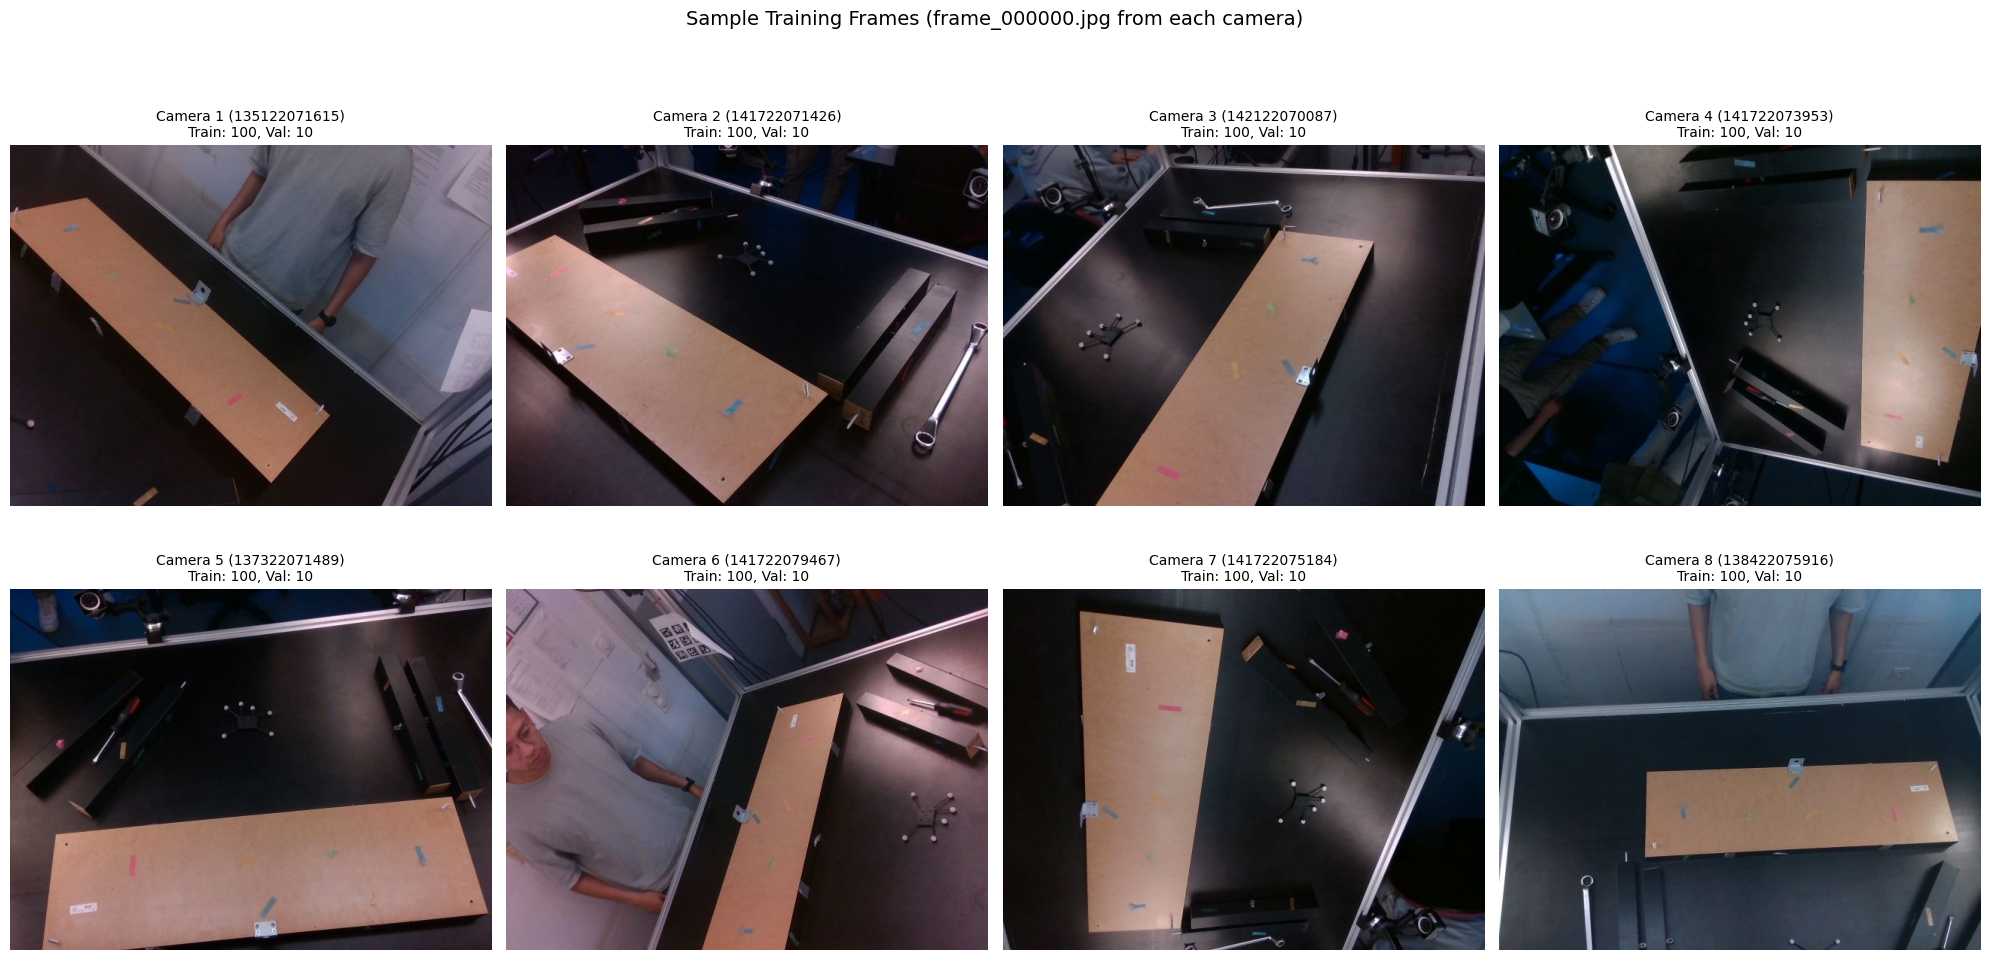


Summary of saved frames:
  Camera 135122071615: 100 train, 10 val
  Camera 141722071426: 100 train, 10 val
  Camera 142122070087: 100 train, 10 val
  Camera 141722073953: 100 train, 10 val
  Camera 137322071489: 100 train, 10 val
  Camera 141722079467: 100 train, 10 val
  Camera 141722075184: 100 train, 10 val
  Camera 138422075916: 100 train, 10 val

Total: 800 training frames, 80 validation frames
Total size: 773.4 MB (estimated)


In [10]:
# Verify saved frames by displaying a sample from each camera
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, serial in enumerate(camera_serials):
    train_path = train_dir / serial / "frame_000000.jpg"
    if train_path.exists():
        img = cv2.imread(str(train_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img_rgb)
        
        # Count saved files
        train_count = len(list((train_dir / serial).glob("*.jpg")))  
        val_count = len(list((val_dir / serial).glob("*.jpg")))
        
        axes[idx].set_title(f'Camera {idx+1} ({serial})\nTrain: {train_count}, Val: {val_count}', fontsize=10)
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, f'Camera {idx+1}\nNo frames saved', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'Camera {idx+1} ({serial})', fontsize=10)
        axes[idx].axis('off')

plt.suptitle('Sample Training Frames (frame_000000.jpg from each camera)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary of saved frames:")
total_train = 0
total_val = 0
for serial in camera_serials:
    train_count = len(list((train_dir / serial).glob("*.jpg")))
    val_count = len(list((val_dir / serial).glob("*.jpg")))
    total_train += train_count
    total_val += val_count
    print(f"  Camera {serial}: {train_count} train, {val_count} val")

print(f"\nTotal: {total_train} training frames, {total_val} validation frames")
print(f"Total size: {(total_train + total_val) * 640 * 480 * 3 / (1024**2):.1f} MB (estimated)")
